<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

# HMS - Harmful Brain Activity Classification with [KerasCV](https://github.com/keras-team/keras-cv) and [Keras](https://github.com/keras-team/keras)

> The objective of this competition is to classify seizures and other patterns of harmful brain activity in critically ill patients

This notebook guides you through the process of training and inferring a Deep Learning model, specifically EfficientNetV2, using KerasCV on the competition dataset. Specificaclly, this notebook uses spectrogram of the eeg data to classify the patterns.

Fun fact: This notebook is backend-agnostic, supporting TensorFlow, PyTorch, and JAX. Utilizing KerasCV and Keras allows us to choose our preferred backend. Explore more details on [Keras](https://keras.io/keras_core/announcement/).

In this notebook, you will learn:

* Loading the data efficiently using [`tf.data`](https://www.tensorflow.org/guide/data).
* Creating the model using KerasCV presets.
* Training the model.
* Inference and Submission on test data.

**Note**: For a more in-depth understanding of KerasCV, refer to the [KerasCV guides](https://keras.io/guides/keras_cv/).

# 🛠 | Install Libraries  

Since internet access is **disabled** during inference, we cannot install libraries in the usual `!pip install <lib_name>` manner. Instead, we need to install libraries from local files. In the following cell, we will install libraries from our local files. The installation code stays very similar - we just use the `filepath` instead of the `filename` of the library. So now the code is `!pip install <local_filepath>`. 

> The `filepath` of these local libraries look quite complicated, but don't be intimidated! Also `--no-deps` argument ensures that we are not installing any additional libraries.

 !pip install -q /kaggle/input/kerasv3-lib-ds/keras_cv-0.8.2-py3-none-any.whl --no-deps
 
 !pip install -q /kaggle/input/kerasv3-lib-ds/tensorflow-2.15.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl --no-deps
 
 !pip install -q /kaggle/input/kerasv3-lib-ds/keras-3.0.4-py3-none-any.whl --no-deps

# 📚 | Import Libraries 

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch

import keras_cv
import keras
from keras import ops
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
# from tensorflow.keras.applications import EfficientNetV2

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt 

import seaborn as sns

import sklearn.metrics

from sklearn.metrics import multilabel_confusion_matrix

2024-10-14 11:10:50.335681: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 11:10:50.335781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 11:10:50.473824: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Library Versions

In [2]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.15.0
Keras: 3.2.1
KerasCV: 0.8.2


# ⚙️ | Configuration

In [3]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    image_size = [400,300]  # Input image size 
    epochs = 20 # Training epochs mặc định
    batch_size = 64  # Batch size
    lr_mode = "cos" # LR scheduler mode from one of "cos", "step", "exp"
    drop_remainder = True  # Drop incomplete batches
    num_classes = 6 # Number of classes in the dataset 
    class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
    label2name = dict(enumerate(class_names))
    name2label = {v:k for k, v in label2name.items()}

# ♻️ | Reproducibility 
Sets value for random seed to produce similar result in each run.

In [4]:
keras.utils.set_random_seed(CFG.seed)

# 📁 | Dataset Path 

In [5]:
BASE_PATH = "/kaggle/input/hms-harmful-brain-activity-classification"

SPEC_DIR = "/tmp/dataset/hms-hbac"
os.makedirs(SPEC_DIR+'/train_spectrograms', exist_ok=True)
os.makedirs(SPEC_DIR+'/test_spectrograms', exist_ok=True)

# 📖 | Meta Data 

In [6]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['eeg_path'] = f'{BASE_PATH}/train_eegs/'+df['eeg_id'].astype(str)+'.parquet'
df['spec_path'] = f'{BASE_PATH}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.parquet'
df['spec2_path'] = f'{SPEC_DIR}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.npy'
df['class_name'] = df.expert_consensus.copy()
df['class_label'] = df.expert_consensus.map(CFG.name2label)
display(df.head(2))

# Test
# test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
# test_df['eeg_path'] = f'{BASE_PATH}/test_eegs/'+test_df['eeg_id'].astype(str)+'.parquet'
# test_df['spec_path'] = f'{BASE_PATH}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.parquet'
# test_df['spec2_path'] = f'{SPEC_DIR}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.npy'
# display(test_df.head(2))

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec2_path,class_name,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0


## Convert `.parquet` to `.npy`

To facilitate easier data loading, we will convert the EEG spectrograms from `parquet` to `npy` format. This process involves saving the spectrogram data, and since the content of the files remains the same, no significant changes are made. 

> It's worth noting that the `time` column is excluded, as it is not part of the spectrogram.

In [7]:
# Define a function to process a single eeg_id
def process_spec(spec_id, split="train"):
    spec_path = f"{BASE_PATH}/{split}_spectrograms/{spec_id}.parquet"
    spec = pd.read_parquet(spec_path)
#     print(spec)
    spec = spec.fillna(0).values[:, 1:].T # fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
    spec = spec.astype("float32")
    np.save(f"{SPEC_DIR}/{split}_spectrograms/{spec_id}.npy", spec)

# Get unique spec_ids of train and valid data
spec_ids = df["spectrogram_id"].unique()
 
# Parallelize the processing using joblib for training data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "train")
    for spec_id in tqdm(spec_ids, total=len(spec_ids))
)

#  Get unique spec_ids of test data
# test_spec_ids = test_df["spectrogram_id"].unique()

#  Parallelize the processing using joblib for test data
# _ = joblib.Parallel(n_jobs=-1, backend="loky")(
#     joblib.delayed(process_spec)(spec_id, "train")
#     for spec_id in tqdm(test_spec_ids, total=len(test_spec_ids))
# )

  0%|          | 0/11138 [00:00<?, ?it/s]

# 🍚 | DataLoader

This DataLoader first reads `npy` spectrogram files and extracts labeled subsamples using specified `offset` values. Then, it converts the spectrogram data into `log spectrogram` and applies the popular signal augmentation `MixUp`.

> Note that, we are converting the mono channel signal to a 3-channel signal for using "ImageNet" weights of pretrained model.

In [8]:
def build_augmenter(dim=CFG.image_size):
    augmenters = [
        keras_cv.layers.MixUp(alpha=2.0),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.1)), # freq-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # time-masking
#         keras_cv.layers.RandomZoom(height_factor=(-0.1, 0.1), 
#                                    width_factor=(-0.1, 0.1)),
    ]
    
    def augment(img, label, sample_weight=None):
        data = {"images": img, "labels": label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.5:
                data = augmenter(data, training=True)
        if sample_weight is not None:
            return data["images"], data["labels"], sample_weight
        return data["images"], data["labels"]
    
    return augment



def build_decoder(with_labels=True, target_size=CFG.image_size, dtype=32):
    def decode_signal(path, offset=None):
        # Read .npy files and process the signal
        file_bytes = tf.io.read_file(path)
        sig = tf.io.decode_raw(file_bytes, tf.float32)
        sig = sig[1024//dtype:]  # Remove header tag
        sig = tf.reshape(sig, [400, -1])
        
        # Extract labeled subsample from full spectrogram using "offset"
        if offset is not None: 
            offset = offset // 2  # Only odd values are given
            sig = sig[:, offset:offset+300]
            
            # Pad spectrogram to ensure the same input shape of [400, 300]
            pad_size = tf.math.maximum(0, 300 - tf.shape(sig)[1])
            sig = tf.pad(sig, [[0, 0], [0, pad_size]])
            sig = tf.reshape(sig, [400, 300])
        
        # Log spectrogram 
        sig = tf.clip_by_value(sig, tf.math.exp(-4.0), tf.math.exp(8.0)) # avoid 0 in log
        sig = tf.math.log(sig)
        
        # Normalize spectrogram
        sig -= tf.math.reduce_mean(sig)
        sig /= tf.math.reduce_std(sig) + 1e-6
        
        # Mono channel to 3 channels to use "ImageNet" weights
        sig = tf.tile(sig[..., None], [1, 1, 3])
        return sig
    
    def decode_label(label):
        label = tf.one_hot(label, CFG.num_classes)
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [CFG.num_classes])
        return label
    
    def decode_with_labels(path, offset=None, label=None):
        sig = decode_signal(path, offset)
        label = decode_label(label)
        return (sig, label)
    
    return decode_with_labels if with_labels else decode_signal


# from imblearn.over_sampling import SMOTE

# def prepare_smote_data(paths, offsets, labels):
#     decode_fn = build_decoder(with_labels=True)
    
#     signals = []
#     for path, offset in zip(paths, offsets):
#         sig, _ = decode_fn(path, offset, label=None)
#         signals.append(sig.numpy())

#     signals = np.array(signals)
#     labels = np.array(labels)

#     smote = SMOTE(random_state=CFG.seed)
#     signals_resampled, labels_resampled = smote.fit_resample(signals.reshape(signals.shape[0], -1), labels)
#     signals_resampled = signals_resampled.reshape(-1, 400, 300, 3)

#     return signals_resampled, labels_resampled
       
    
def build_dataset(paths, offsets=None, labels=None, sample_weights=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None, augment=False, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
  
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter()
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths, offsets) if labels is None else (paths, offsets, labels)
    
    if sample_weights is not None:
        slices += (sample_weights,)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    
    if sample_weights is not None:
        ds = ds.map(lambda *x: decode_fn(*x[:3]) + (x[3],), num_parallel_calls=AUTO)
    else:
        ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(lambda *x: augment_fn(*x), num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

# 🔪 | Data Split

In the following code snippet, the data is divided into `5` folds. Note that, the `groups` argument is used to prevent any overlap of patients between the training and validation sets, thus avoiding potential **data leakage** issues. Additionally, each split is stratified based on the `class_label`, ensuring a uniform distribution of class labels in each fold.

In [9]:
from sklearn.model_selection import StratifiedGroupKFold

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

df["fold"] = -1
df.reset_index(drop=True, inplace=True)
for fold, (train_idx, valid_idx) in enumerate(
    sgkf.split(df, y=df["class_label"], groups=df["patient_id"])
):
    df.loc[valid_idx, "fold"] = fold
df.groupby(["fold", "class_name"])[["eeg_id"]].count().T

fold           0                                     1                    ...  \
class_name   GPD  GRDA   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA  ...   
eeg_id      2050  2605  1168  3793  3462    4007  4832  4856  4463  3117  ...   

fold           3                         4                                  
class_name   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA Other Seizure  
eeg_id      2318  4296  3884    4787  1889  3700  4249  3002  4013    4045  

[1 rows x 30 columns]

## Build Train & Valid Dataset

Only first sample for each `spectrogram_id` is used in order to keep the dataset size managable. Feel free to train on full data.

the **first** `spectrogram_sub_id` for each `spectrogram_id`

In [10]:
# Sample from full data
sample_df = df.groupby("spectrogram_id").head(1).reset_index(drop=True)

train_df = sample_df[sample_df["fold"].isin([2,3,4])]
valid_df = sample_df[sample_df.fold == 0] 
test_df = sample_df[sample_df.fold == 1] 
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}  | Num Test: {len(test_df)}")

print("Train class distribution percentages:")
print(train_df["class_label"].value_counts())#/len(train_df))*100)
print("Valid class distribution percentages:")
print(valid_df["class_label"].value_counts())#/len(valid_df))*100)
print("Test class distribution percentages:")
print(test_df["class_label"].value_counts())#/len(test_df))*100)

# Train
train_paths = train_df.spec2_path.values
train_offsets = train_df.spectrogram_label_offset_seconds.values.astype(int)
train_labels = train_df.class_label.values 

from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(train_labels)
class_weights = compute_class_weight('balanced', classes=classes, y=train_labels)
class_weights_dict = dict(enumerate(class_weights))
# class_weights_dict[5]=0.0001
sample_weights = np.array([class_weights_dict[class_label] for class_label in train_labels])
print(class_weights_dict)

train_dsNA = build_dataset(train_paths, train_offsets, train_labels, batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=False, cache=True, sample_weights=None)
train_ds = build_dataset(train_paths, train_offsets, train_labels, batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=True, cache=True, sample_weights=None)

# Valid
valid_paths = valid_df.spec2_path.values
valid_offsets = valid_df.spectrogram_label_offset_seconds.values.astype(int)
valid_labels = valid_df.class_label.values
valid_ds = build_dataset(valid_paths, valid_offsets, valid_labels, batch_size=CFG.batch_size,
                         repeat=False, shuffle=True, augment=False, cache=True,sample_weights=None)

#Test
test_paths = test_df.spec2_path.values
test_offsets = test_df.spectrogram_label_offset_seconds.values.astype(int)
test_labels = test_df.class_label.values
test_ds = build_dataset(test_paths, test_offsets, test_labels, batch_size=min(CFG.batch_size, len(test_df)),
                        repeat=False, shuffle=False, augment=False, cache=False, sample_weights=None)
# 

# Num Train: 6946 | Num Valid: 1972  | Num Test: 2220
Train class distribution percentages:
class_label
5    2863
0    1229
4     887
1     844
2     716
3     407
Name: count, dtype: int64
Valid class distribution percentages:
class_label
5    947
0    360
4    235
1    170
3    130
2    130
Name: count, dtype: int64
Test class distribution percentages:
class_label
5    889
0    456
4    300
1    270
2    179
3    126
Name: count, dtype: int64
{0: 0.9419582316246271, 1: 1.3716429699842023, 2: 1.616852886405959, 3: 2.8443898443898443, 4: 1.3051484404359264, 5: 0.40435440679939455}


## Dataset Check

Let's visualize some samples from the dataset.

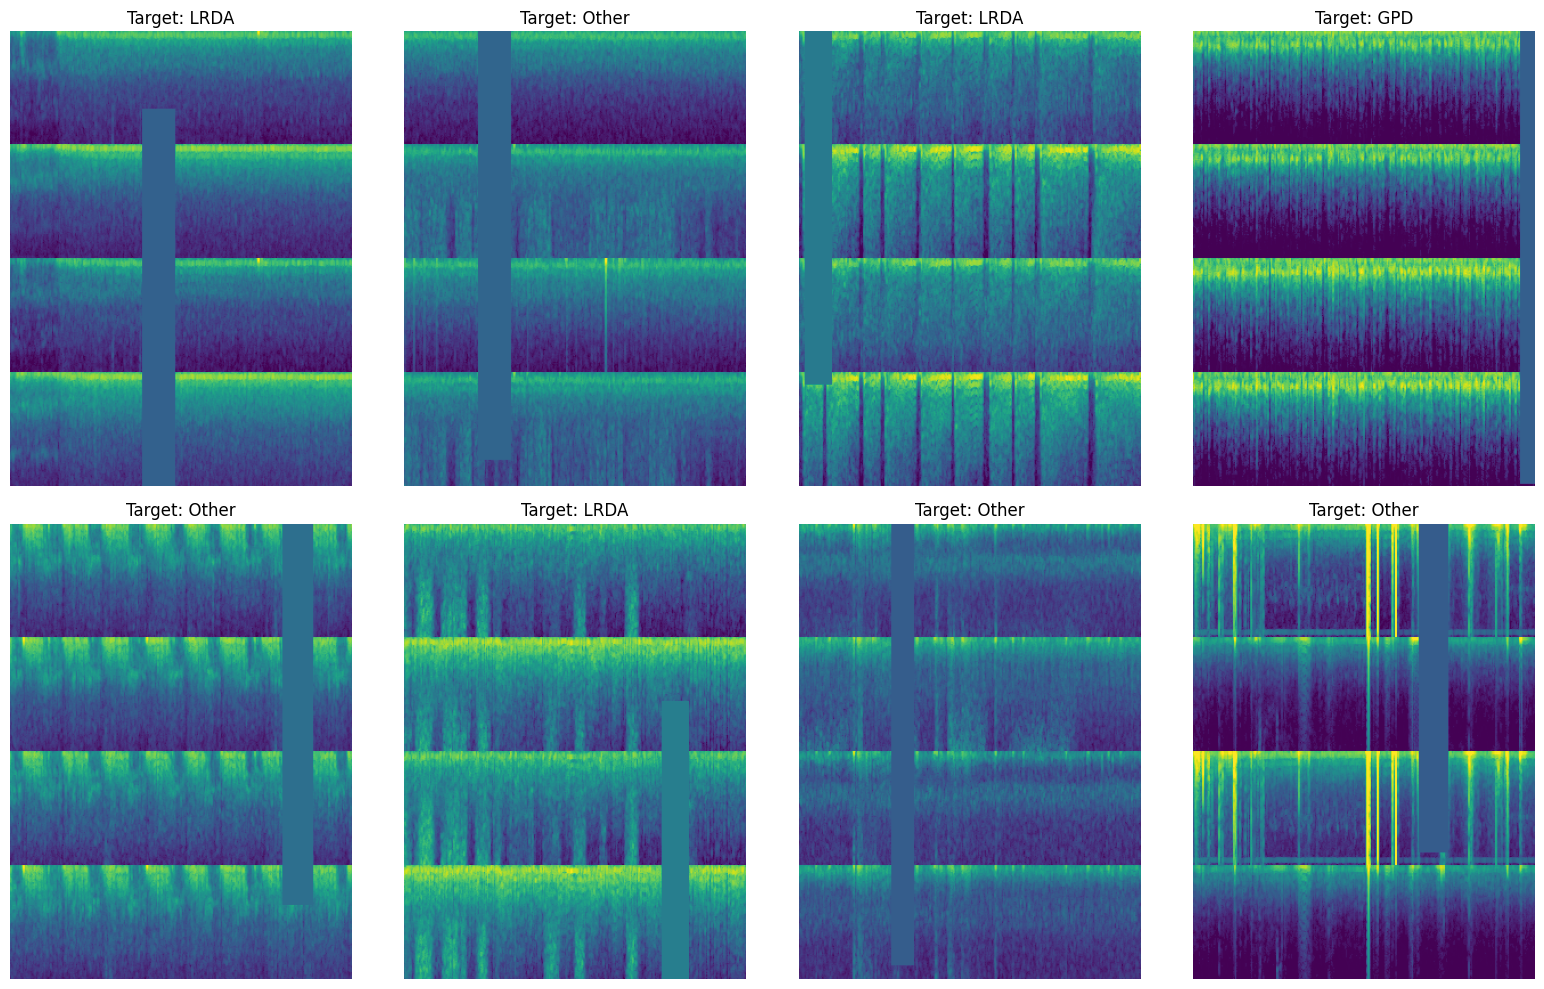

In [11]:
imgs, tars  = next(iter(train_ds))
# imgs, tars,sample_weights  = next(iter(train_dsNA))
num_imgs = 8
plt.figure(figsize=(4*4, num_imgs//4*5))
for i in range(num_imgs):
    plt.subplot(num_imgs//4, 4, i + 1)
    img = imgs[i].numpy()[...,0]  # Adjust as per your image data format
    img -= img.min()
    img /= img.max() + 1e-4
    tar = CFG.label2name[np.argmax(tars[i].numpy())]
    plt.imshow(img)
    plt.title(f"Target: {tar}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [12]:
def plot_hist(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show() 

# 🔍 | Loss & Metric

The evaluation metric in this competition is **KL Divergence**, defined as,

$$
D_{\text{KL}}(P \parallel Q) = \sum_{i} P(i) \log\left(\frac{P(i)}{Q(i)}\right)
$$

Where:
- $P$ is the true distribution.
- $Q$ is the predicted distribution.

Interestingly, as KL Divergence is differentiable, we can directly use it as our loss function. Thus, we don't need to use a third-party metric like **Accuracy** to evaluate our model. Therefore, `valid_loss` can stand alone as an indicator for our evaluation. In keras, we already have impelementation for KL Divergence loss so we only need to import it.

In [13]:
LOSS = keras.losses.KLDivergence()

# 🤖 | Modeling

This notebook uses the `EfficientNetV2 B2` from KerasCV's collection of pretrained models. To explore other models, simply modify the `preset` in the `CFG` (config). Check the [KerasCV website](https://keras.io/api/keras_cv/models/tasks/image_classifier/) for a list of available pretrained models.

In [14]:
# Build Classifier
model0 = keras_cv.models.ImageClassifier.from_preset(
    CFG.preset, num_classes=CFG.num_classes
)    
model0.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=LOSS, metrics =['accuracy', 'precision', 'recall','f1_score'])
 
model0.summary()

#----------------------------------------------------------------------------

# from tensorflow.keras.layers import Dense, BatchNormalization, Activation
# # Build new Classifier
# base_model1 = keras_cv.models.ImageClassifier.from_preset(
#     CFG.preset, num_classes=CFG.num_classes
# ) 

# # Freeze all layers in the base model
# for layer in base_model1.layers:
#     layer.trainable = False  
# base_model_layers = base_model1.layers[:-1]

# model1 = keras.Sequential() 
# # Add the layers of the base model excluding the classification head
# for layer in base_model1.layers[:-1]:
#     model1.add(layer)
# model1.summary()

# # Add Dropout, Dense  
# # model1.add(Dropout(0.5))
# model1.add(Dense(1408, activation='relu'))
# model1.add(BatchNormalization())
# model1.add(Dropout(0.1))
# model1.add(Dense(CFG.num_classes, activation='softmax'))

# model1.compile(optimizer=keras.optimizers.Nadam(learning_rate=1e-4),
#               loss=LOSS, metrics =['accuracy', 'precision', 'recall','f1_score'])
 
# model1.summary() 
#---------------------------------------------------------------------------
# Build new Classifier
base_model1 = keras_cv.models.ImageClassifier.from_preset(
    CFG.preset, num_classes=CFG.num_classes
) 
# Freeze all layers in the base model
# for layer in base_model1.layers:
#     layer.trainable = False  
# base_model_layers = base_model.layers[:-1]

model1 = keras.Sequential() 
# Add the layers of the base model excluding the classification head
for layer in base_model1.layers[:-1]:
    model1.add(layer)
model1.summary()

# Add Dropout, Dense and GlobalAveragePooling2D layers  
model1.add(Dropout(0.5))
# model1.add(Dense(1408, activation='relu'))
# model1.add(Dropout(0.1))
model1.add(Dense(CFG.num_classes, activation='softmax'))

model1.compile(optimizer=keras.optimizers.Nadam(learning_rate=1e-4),
              loss=LOSS, metrics =['accuracy', 'precision', 'recall','f1_score'])
 
model1.summary() 

Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...


Model: "image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficient_net_v2b2_backbone     │ (None, None, None,     │     8,769,374 │
│ (EfficientNetV2Backbone)        │ 1408)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 8,695,540 (33.17 MB)

 Non-trainable params: 82,288 (321.44 KB)

Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficient_net_v2b2_backbone     │ (None, None, None,     │     8,769,374 │
│ (EfficientNetV2Backbone)        │ 1408)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 8,687,086 (33.14 MB)

 Non-trainable params: 82,288 (321.44 KB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficient_net_v2b2_backbone     │ (None, None, None,     │     8,769,374 │
│ (EfficientNetV2Backbone)        │ 1408)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 8,695,540 (33.17 MB)

 Non-trainable params: 82,288 (321.44 KB)

# ⚓ | LR Schedule

A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [15]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 6e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

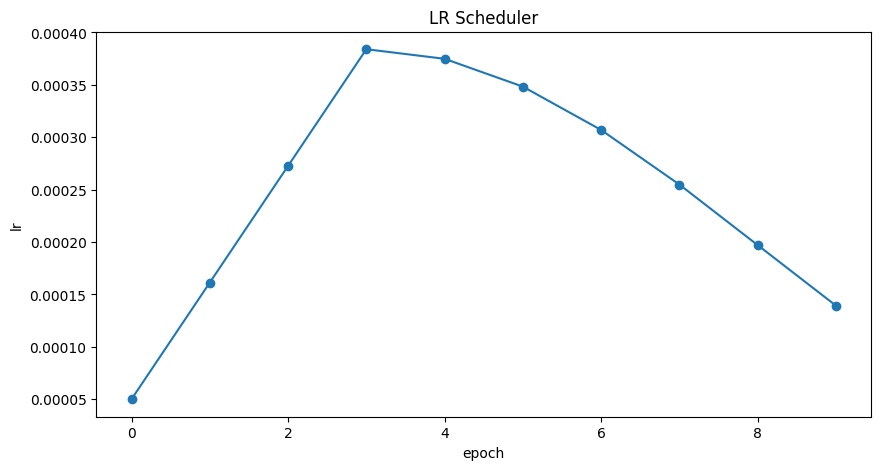

In [16]:
lr_cb = get_lr_callback(CFG.batch_size, mode=CFG.lr_mode, plot=True)

exp thì bị overfit

# 💾 | Model Checkpointing

In [17]:
ckpt_cb0 = keras.callbacks.ModelCheckpoint("best_model0.keras",
                                         monitor='val_loss',
                                         save_best_only=True,
                                         save_weights_only=False,
                                         mode='min')

In [18]:
ckpt_cb1 = keras.callbacks.ModelCheckpoint("best_model1.keras",
                                         monitor='val_loss',
                                         save_best_only=True,
                                         save_weights_only=False,
                                         mode='min')

In [19]:
# ckpt_cb2 = keras.callbacks.ModelCheckpoint("best_model2.keras",
#                         
monitor='val_loss',
#                                          save_best_only=True,
#                                          save_weights_only=False,
#                                          mode='min')

# thêm batch nomal

# 🚂 | Training

In [20]:
# label_counts = np.bincount(train_labels.astype(np.int64))
# class_weights  = 1.0 / label_counts.astype(float)
# class_weights = class_weights / np.sum(class_weights)
# class_weights[5]=0.001
# class_weights = dict(enumerate(class_weights))

In [21]:
history0 = model0.fit(
    train_dsNA, 
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb0],# early_stopping], 
    steps_per_epoch=len(train_df)//CFG.batch_size,
    validation_data=valid_ds, 
    verbose=CFG.verbose#,
#     class_weight=class_weights
)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 133s 679ms/step - accuracy: 0.3470 - f1_score: 0.1469 - loss: 1.6583 - precision: 0.4517 - recall: 0.0120 - val_accuracy: 0.5030 - val_f1_score: 0.2120 - val_loss: 1.3831 - val_precision: 0.7491 - val_recall: 0.1075 - learning_rate: 5.0000e-05
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 55s 509ms/step - accuracy: 0.6759 - f1_score: 0.5630 - loss: 0.8674 - precision: 0.7662 - recall: 0.5781 - val_accuracy: 0.6455 - val_f1_score: 0.5339 - val_loss: 0.9746 - val_precision: 0.6967 - val_recall: 0.5614 - learning_rate: 3.8400e-04
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 54s 497ms/step - accuracy: 0.7327 - f1_score: 0.6498 - loss: 0.7319 - precision: 0.8047 - recall: 0.6525 - val_accuracy: 0.6237 - val_f1_score: 0.5325 - val_loss: 1.0359 - val_precision: 0.6749 - val_recall: 0.5568 - learning_rate: 3.7485e-04
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 53s 495ms/step - accuracy: 0.7821 - f1_score: 0.7169 - loss: 0.6043 - precision: 0.8370 - recall: 0.7123 - val

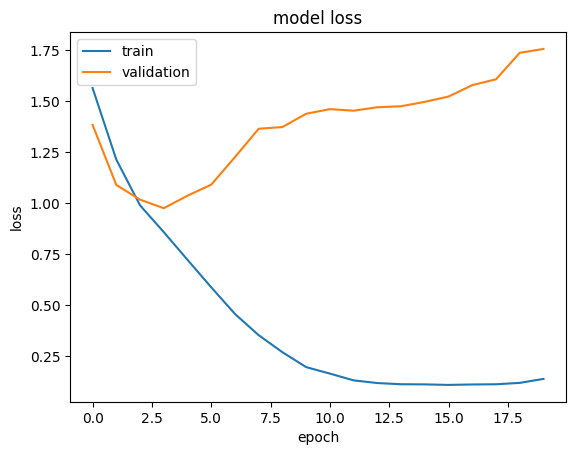

In [22]:
plot_hist(history0) 

In [23]:
model0.load_weights("best_model0.keras")

In [24]:
preds0 = model0.predict(test_ds) 
preds0 = np.argmax(preds0, axis=-1)  # Chuyển đổi dự đoán thành nhãn phân loại 

35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step


              precision    recall  f1-score   support

     Seizure       0.71      0.58      0.64       456
         LPD       0.78      0.70      0.74       270
         GPD       0.60      0.59      0.59       179
        LRDA       0.49      0.15      0.23       126
        GRDA       0.53      0.66      0.58       300
       Other       0.68      0.78      0.73       889

    accuracy                           0.66      2220
   macro avg       0.63      0.58      0.59      2220
weighted avg       0.66      0.66      0.65      2220

[[265   8  32   3  12 136]
 [ 17 190  10   4   8  41]
 [ 18   8 105   0  10  38]
 [ 14   6   1  19  58  28]
 [  9   4   3   5 197  82]
 [ 48  28  24   8  90 691]]


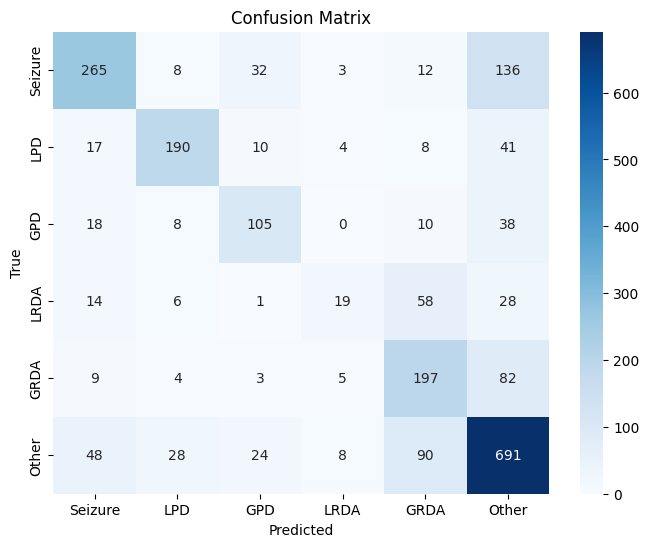

In [25]:
test_labels = np.argmax(test_labels, axis=-1) if len(test_labels.shape) > 1 else test_labels
from sklearn.metrics import classification_report, confusion_matrix
# In báo cáo phân loại
print(classification_report(test_labels, preds0, target_names=CFG.class_names))

# In ma trận nhầm lẫn
cm = confusion_matrix(test_labels, preds0)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CFG.class_names, yticklabels=CFG.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [26]:
test_results = model0.evaluate(test_ds, verbose=CFG.verbose)
 # In ra kết quả
for metric_name, result in zip(model0.metrics_names, test_results):
    print('\n'f"{metric_name}: {result}") 

35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - accuracy: 0.6777 - f1_score: 0.5997 - loss: 0.9338 - precision: 0.7399 - recall: 0.5984

loss: 0.9658518433570862

compile_metrics: 0.6608107686042786


In [27]:
history00 = model0.fit(
    train_ds, 
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb0],# early_stopping], 
    steps_per_epoch=len(train_df)//CFG.batch_size,
    validation_data=valid_ds, 
    verbose=CFG.verbose#,
#     class_weight=class_weights
)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 59s 544ms/step - accuracy: 0.6517 - f1_score: 0.5084 - loss: 0.8503 - precision: 0.8000 - recall: 0.4462 - val_accuracy: 0.6577 - val_f1_score: 0.5166 - val_loss: 0.9609 - val_precision: 0.7229 - val_recall: 0.5756 - learning_rate: 5.0000e-05
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 56s 521ms/step - accuracy: 0.6897 - f1_score: 0.5618 - loss: 0.7773 - precision: 0.8446 - recall: 0.4494 - val_accuracy: 0.6714 - val_f1_score: 0.5648 - val_loss: 0.9260 - val_precision: 0.7357 - val_recall: 0.5730 - learning_rate: 1.6133e-04
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 55s 505ms/step - accuracy: 0.6839 - f1_score: 0.5440 - loss: 0.7874 - precision: 0.8562 - recall: 0.4361 - val_accuracy: 0.6592 - val_f1_score: 0.5602 - val_loss: 0.9679 - val_precision: 0.7281 - val_recall: 0.5593 - learning_rate: 2.7267e-04
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 54s 499ms/step - accuracy: 0.7009 - f1_score: 0.5740 - loss: 0.7361 - precision: 0.8488 - recall: 0.4725 - val_

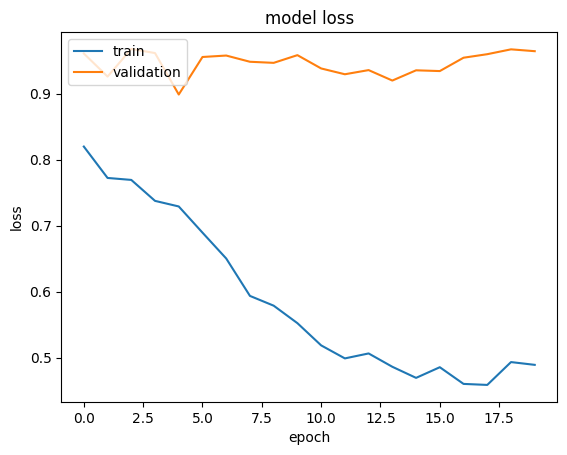

In [28]:
plot_hist(history00) 

In [29]:
model0.load_weights("best_model0.keras")

In [30]:
preds00 = model0.predict(test_ds) 
preds00 = np.argmax(preds00, axis=-1) 

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 598ms/step


              precision    recall  f1-score   support

     Seizure       0.64      0.68      0.66       456
         LPD       0.75      0.71      0.73       270
         GPD       0.57      0.59      0.58       179
        LRDA       0.49      0.13      0.21       126
        GRDA       0.57      0.46      0.51       300
       Other       0.66      0.76      0.71       889

    accuracy                           0.65      2220
   macro avg       0.61      0.56      0.57      2220
weighted avg       0.64      0.65      0.64      2220

[[312   8  36   1   6  93]
 [ 26 193  10   3   4  34]
 [ 19  11 105   0   8  36]
 [ 17   9   1  17  38  44]
 [ 16   7   2   3 139 133]
 [ 97  31  29  11  49 672]]


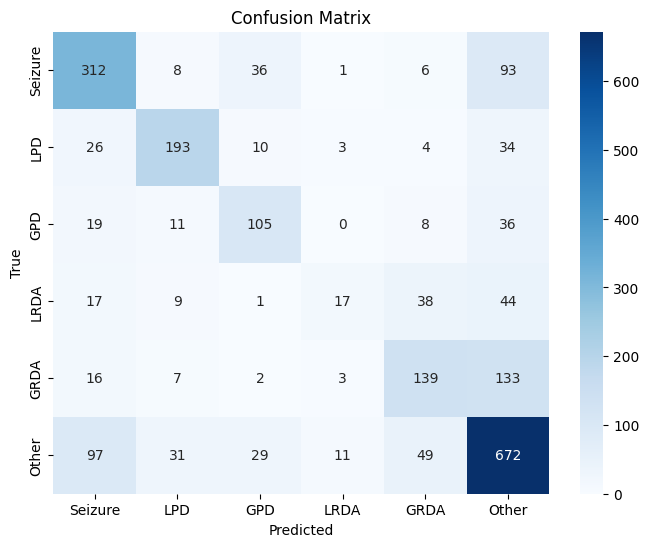

In [31]:
test_labels = np.argmax(test_labels, axis=-1) if len(test_labels.shape) > 1 else test_labels
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_labels, preds00, target_names=CFG.class_names))

cm = confusion_matrix(test_labels, preds00)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CFG.class_names, yticklabels=CFG.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [32]:
# Đánh giá mô hình trên tập kiểm tra
# Basemodel có augment
test_results = model0.evaluate(test_ds, verbose=CFG.verbose)
 # In ra kết quả
for metric_name, result in zip(model0.metrics_names, test_results):
    print('\n'f"{metric_name}: {result}") 

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 259ms/step - accuracy: 0.6606 - f1_score: 0.5773 - loss: 0.8911 - precision: 0.7253 - recall: 0.5872

loss: 0.9242339730262756

compile_metrics: 0.6477476954460144


In [33]:
history1 = model1.fit(
    train_ds, 
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb1],# early_stopping], 
    steps_per_epoch=len(train_df)//CFG.batch_size,
    validation_data=valid_ds, 
    verbose=CFG.verbose#,
#     class_weight=class_weights
)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 133s 640ms/step - accuracy: 0.3193 - f1_score: 0.1631 - loss: 1.4928 - precision: 0.3499 - recall: 0.0043 - val_accuracy: 0.4802 - val_f1_score: 0.1081 - val_loss: 1.4372 - val_precision: 0.6250 - val_recall: 0.0330 - learning_rate: 5.0000e-05
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 60s 551ms/step - accuracy: 0.4448 - f1_score: 0.1879 - loss: 1.2492 - precision: 0.7205 - recall: 0.1027 - val_accuracy: 0.5811 - val_f1_score: 0.4069 - val_loss: 1.1562 - val_precision: 0.7398 - val_recall: 0.3692 - learning_rate: 1.6133e-04
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 60s 559ms/step - accuracy: 0.5420 - f1_score: 0.3683 - loss: 1.0347 - precision: 0.7730 - recall: 0.2817 - val_accuracy: 0.6303 - val_f1_score: 0.4657 - val_loss: 1.0224 - val_precision: 0.7204 - val_recall: 0.4914 - learning_rate: 2.7267e-04
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 58s 540ms/step - accuracy: 0.6030 - f1_score: 0.4499 - loss: 0.9408 - precision: 0.7869 - recall: 0.3619 - val

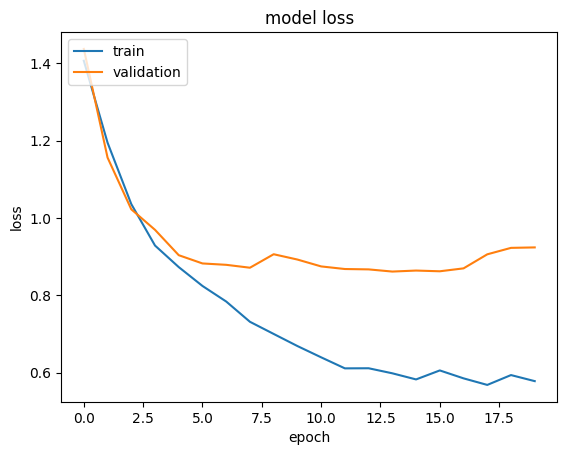

In [34]:
plot_hist(history1)

In [35]:
model1.load_weights("best_model1.keras")

In [36]:
preds1 = model1.predict(test_ds)
preds1 = np.argmax(preds1, axis=-1)

test_labels = np.argmax(test_labels, axis=-1) if len(test_labels.shape) > 1 else test_labels

# In báo cáo phân loại
print(classification_report(test_labels, preds1, target_names=CFG.class_names))

# In ma trận nhầm lẫn
cm = confusion_matrix(test_labels, preds1)
print(cm)

35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 589ms/step
              precision    recall  f1-score   support

     Seizure       0.68      0.64      0.66       456
         LPD       0.82      0.67      0.74       270
         GPD       0.61      0.66      0.63       179
        LRDA       0.67      0.28      0.39       126
        GRDA       0.61      0.56      0.58       300
       Other       0.68      0.80      0.73       889

    accuracy                           0.68      2220
   macro avg       0.68      0.60      0.62      2220
weighted avg       0.68      0.68      0.67      2220

[[290   7  34   1  12 112]
 [ 21 181  11   1   6  50]
 [ 20   4 118   0   8  29]
 [ 13   5   1  35  27  45]
 [ 11   6   7   7 167 102]
 [ 74  19  22   8  54 712]]


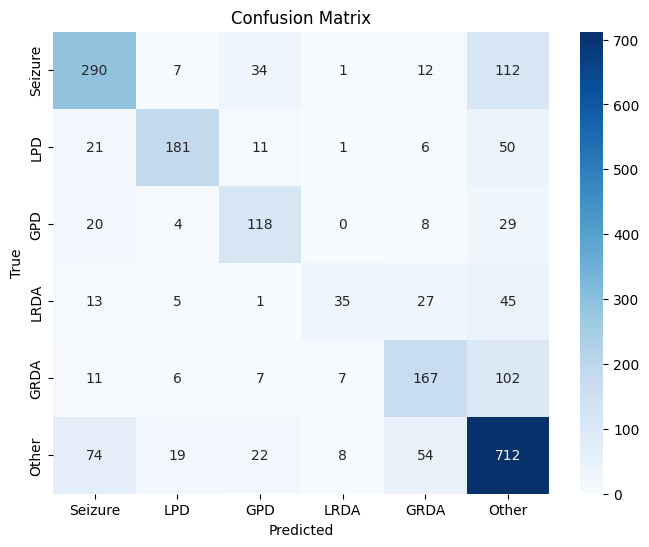

In [37]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CFG.class_names, yticklabels=CFG.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [38]:
test_results = model1.evaluate(test_ds, verbose=CFG.verbose)
for metric_name, result in zip(model1.metrics_names, test_results):
    print('\n'f"{metric_name}: {result}") 

35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 408ms/step - accuracy: 0.6959 - f1_score: 0.6432 - loss: 0.8546 - precision: 0.7426 - recall: 0.6454

loss: 0.8987436890602112

compile_metrics: 0.6770269870758057


In [39]:
# label_counts = np.bincount(train_labels.astype(np.int64))
# print(train_labels)
# class_weights  = 1.0 / label_counts.astype(float)
# class_weights = class_weights / np.sum(class_weights)
# class_weights[5]=0.001
# class_weights = dict(enumerate(class_weights))
# # In ra các trọng số
# print("Các trọng số cho từng nhãn:\n", class_weights)


-----------------------------------------------
BỎ DROPOUT

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.6912 - f1_score: 0.6291 - loss: 0.8685 - precision: 0.7405 - recall: 0.6219

loss: 0.901387631893158

compile_metrics: 0.6752251982688904

-----------------------------------------------
CÓ DROPOUT

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - accuracy: 0.6918 - f1_score: 0.6272 - loss: 0.8494 - precision: 0.7676 - recall: 0.5882

loss: 0.8920499682426453

compile_metrics: 0.6743242740631104

-----------------------------------------------

Confusion matrix for class 'Seizure':
[[ 302  154]
 [ 183 1581]]

Confusion matrix for class 'LPD':
[[ 187   83]
 [ 115 1835]]

Confusion matrix for class 'GPD':
[[ 146   33]
 [ 165 1876]]

Confusion matrix for class 'LRDA':
[[  66   60]
 [ 144 1950]]

Confusion matrix for class 'GRDA':
[[ 179  121]
 [ 127 1793]]

Confusion matrix for class 'Other':
[[ 481  408]
 [ 125 1206]]
 
 
 6949/từng mẫu
label_counts = np.bincount(train_labels.astype(np.int64))
class_weights  = 1.0 / label_counts.astype(float)
class_weights = class_weights / np.sum(class_weights)

 In ra các trọng số
print("Các trọng số cho từng nhãn:\n", class_weights)

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.6248 - f1_score: 0.5944 - loss: 1.0000 - precision: 0.7007 - recall: 0.5005

loss: 1.0192819833755493

compile_metrics: 0.6130630373954773

trọng số 2863 1 lớp  dropout => overfit

In [40]:
# from tensorflow.keras.utils import to_categorical

# # Số lượng mẫu cho mỗi nhãn
# label_counts = {
#     0: 1229,
#     1: 844,
#     2: 716,
#     3: 407,
#     4: 887,
#     5: 2863
# }

# # Số lượng mẫu của nhãn ít xuất hiện nhất
# min_samples = min(label_counts.values())

# # Tính trọng số
# class_weights = {label: min_samples / count for label, count in label_counts.items()}

# print("Trọng số cho mỗi nhãn:")
# for label, weight in class_weights.items():
#     print(f'Nhãn {label}: Trọng số: {weight:.2f}')

# # Chuyển đổi thành định dạng phù hợp để sử dụng trong model.fit()
# class_weight_dict = {i: weight for i, weight in enumerate(class_weights.values())} 

# 📌 | Reference
* [HMS-HBAC: ResNet34d Baseline [Training]](https://www.kaggle.com/code/ttahara/hms-hbac-resnet34d-baseline-training) 
* [EfficientNetB2 Starter - [LB 0.57]](https://www.kaggle.com/code/cdeotte/efficientnetb2-starter-lb-0-57)

In [41]:
!cat /kaggle/input/efficientnetv2/keras/efficientnetv2_b2_imagenet/2/config.json


{
    "module": "keras_cv.src.models.backbones.efficientnet_v2.efficientnet_v2_backbone",
    "class_name": "EfficientNetV2Backbone",
    "config": {
        "name": "efficient_net_v2b2_backbone",
        "trainable": true,
        "include_rescaling": true,
        "width_coefficient": 1.1,
        "depth_coefficient": 1.2,
        "skip_connection_dropout": 0.2,
        "depth_divisor": 8,
        "min_depth": 8,
        "activation": "swish",
        "input_shape": [
            null,
            null,
            3
        ],
        "input_tensor": null,
        "stackwise_kernel_sizes": [
            3,
            3,
            3,
            3,
            3,
            3
        ],
        "stackwise_num_repeats": [
            1,
            2,
            2,
            3,
            5,
            8
        ],
        "stackwise_input_filters": [
            32,
            16,
            32,
            48,
            96,
            112
        ],
        "stackwise_